# Minimum Wage Simulation -- Estimator Comparisons



In [90]:
import os
# set wd to Users/boyuchen/Documents/UBC/RA/minimum_wage
os.chdir('/Users/boyuchen/Documents/UBC/RA/minimum_wage')

from codes.simulation_functions import *
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

**Purpose**: demonstrate whether the three methods worked as expected.

**TL;DR:** 

1. Scenarios of choice: two truncated scenarios with no bunching and spillovers; then one with bunching and one with spillover.
2. Cengiz et al(2019) did a good job in not producing spurious spillover effect.
3. Percentile method gives the spurious "spillover effect" in S1 to S3.
4. My hazard estimates results have significant effect on bins above the minimum wage bin, which is not what I expected. 

In [91]:
log_wages = generate_log_wages(1_000_000)  
# run df_grouped for four proability scenarios:
# real_m_pre, real_m_post, P_o, P_b, P_s
scenarios = {
    'S1': (12, 14, 0.5, 0, 0),
    'S2': (12, 14, 0.5, 0.05, 0),
    'S3': (12, 14, 0.5, 0, 0.3),
    'S4': (14, 16, 0.5, 0, 0),
    'S5': (14, 16, 0.5, 0.05, 0),
    'S6': (14, 16, 0.5, 0, 0.3)
}

# scenarios = {
#     'S1': (10.05, 12.05, 0.3, 0.5, 0),
#     'S2': (10.05, 12.05, 0.3, 0, 0.5),
#     'S3': (13.05, 15.05, 0.3, 0.5, 0),
#     'S4': (13.05, 15.05, 0.3, 0, 0.5),
# }

## Naive percentile OLS


In [92]:
def calculate_percentiles(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    df_pre = impose_minimum_wage(log_wages, real_m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, real_m_post, P_o, P_b, P_s)

    def to_real_scale(log_wages):
        return np.exp(log_wages)

    df_pre['real_wages'] = to_real_scale(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = to_real_scale(df_post['adjusted_log_wages'])

    percentiles = np.arange(0, 85, 5)

    pre_percentiles = np.percentile(df_pre['real_wages'].dropna(), percentiles)
    post_percentiles = np.percentile(df_post['real_wages'].dropna(), percentiles)
    
    # Calculate 95th percentile
    p95_pre = np.percentile(df_pre['real_wages'].dropna(), 95)
    p95_post = np.percentile(df_post['real_wages'].dropna(), 95)
    x_limit = max(p95_pre, p95_post)

    return pre_percentiles, post_percentiles, df_pre['real_wages'].dropna(), df_post['real_wages'].dropna(), x_limit


The figure shows the relative changes in precentiles as the minimum wage changes. As expected, all percentiles "inflated" as some more people got unemployed. We got bad results as expected.

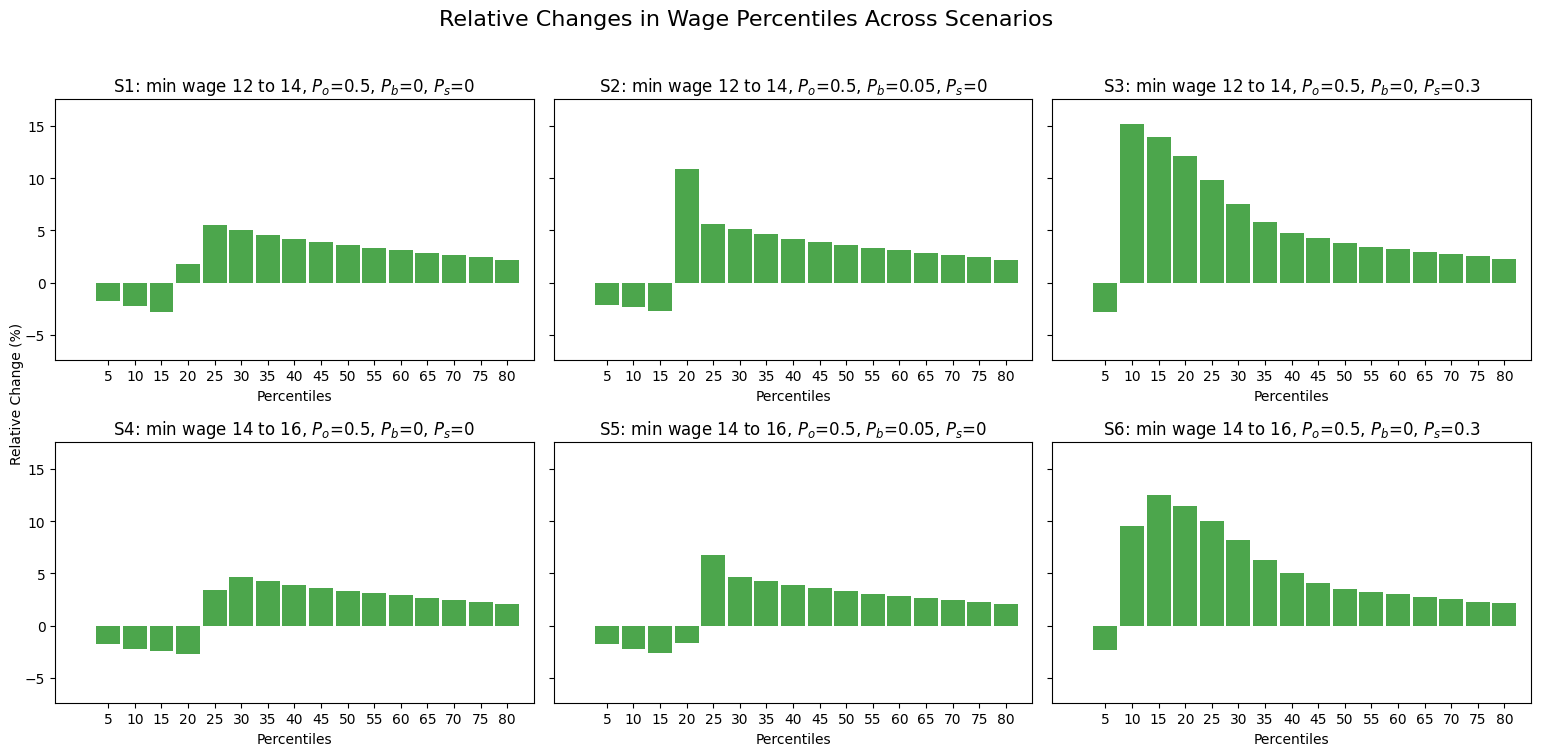

In [93]:
# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Generate and plot results for each scenario
for i, (scenario_name, params) in enumerate(scenarios.items()):
    pre_percentiles, post_percentiles, _, _, x_limit = calculate_percentiles(log_wages, params)
    relative_changes = (post_percentiles - pre_percentiles) / pre_percentiles * 100

    ax = axes[i]
    percentiles = np.arange(5, 85, 5)


    ax.bar(percentiles, relative_changes[1:], width=4.5, alpha=0.7, color='green')
    ax.set_xlabel('Percentiles')
    # ax.set_ylabel('Relative Change (%)')
    ax.set_title(f'{scenario_name}: min wage {params[0]} to {params[1]}, $P_o$={params[2]}, $P_b$={params[3]}, $P_s$={params[4]}')
    ax.set_xticks(percentiles)
    ax.set_xlim([-5, 85])
    ax.set_ylim([min(relative_changes[1:]) - 5, max(relative_changes[1:]) + 5])

# Set the main title
plt.suptitle('Relative Changes in Wage Percentiles Across Scenarios', fontsize=16)
fig.text(0.04, 0.5, 'Relative Change (%)', va='center', rotation='vertical')

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


## Cengiz et al.(2019) Method

In this section, I simplify the regression model in Cengiz et al.(2019). I then present the simulation results in two ways. The first is to plot the regression coefficients, and the second is to replicate the main result figure in their paper, which shows the difference in actual and counterfactual employment based on the regression results. The first method should be more comparable to the hazard estimates, although the coefficient can't be related directly.

I simplified the regression model in their paper into the following specification:

$$
\frac{E_{jt}}{N_t} = \beta_0 + \sum_{k=-20}^{20} \alpha_k I_{jt}^{k} + \mu_j + u_{jt}
$$

- $E_{jt}$: employment at time $t$ in bin $j$,
- $N_t$: total population at time $t$,
- $I_{jt}^{k}$: indicator that equals 1 if the $jt$ bin-time pair is $k$ bins above/below the minimum wage. Here we allow $k$ from -20 to 20,
- $\alpha_k$: coefficient of desired. I also include bin fixed effect and a intercept in the model,
- $\mu_j$: bin fixed effect.


In [169]:
def prepare_cengiz_data(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario

    total_population = log_wages.shape[0]

    # Assume impose_minimum_wage is defined and applies the minimum wage policy to the data
    df_pre = impose_minimum_wage(log_wages, real_m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, real_m_post, P_o, P_b, P_s)

    df_pre['real_wages'] = np.exp(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = np.exp(df_post['adjusted_log_wages'])

    # Simplify bins
    bins = [0] + list(np.arange(3, 4, 0.5)) + list(np.arange(4, 20, 0.1)) + [20, np.inf]

    def create_min_dummies(df, real_m):
        # Create bins and labels
        df['wagcat'] = pd.cut(df['real_wages'], bins=bins, labels=False, duplicates='drop')
        # Change wagcat to be integer or NaN
        df['wagcat'] = df['wagcat'].astype('Int64')

        # Find the bin number containing the minimum wage
        m_bin = pd.cut([real_m], bins=bins, labels=False, duplicates='drop')[0]

        # Aggregate data by bin
        df_grouped = df.groupby('wagcat').size().reset_index(name='fweight')
        df_grouped['normalized_emp'] = df_grouped['fweight'] / total_population
        max_bin = df_grouped['wagcat'].max()
        all_bins = pd.DataFrame({'wagcat': range(max_bin + 1)})
        df_grouped = pd.merge(all_bins, df_grouped, on='wagcat', how='left').fillna(0)

        # Create min and variables that the relative position to the minimum wage
        df_grouped['rel_pos'] = df_grouped['wagcat'] - m_bin

        # Create bin* dummies
        bin_dummies = pd.get_dummies(df_grouped['wagcat'], prefix='bin')

        for i in range(20):
            # create min* dummies
            df_grouped[f'min{i+1}b'] = (df_grouped['rel_pos'] == -(i+1)).astype(int)

        for i in range(20):
            # create min* dummies
            df_grouped[f'min{i+1}a'] = (df_grouped['rel_pos'] == i+1).astype(int)

        df_grouped['min0'] = df_grouped['rel_pos'] == 0

        df_grouped = pd.concat([df_grouped, bin_dummies], axis=1)
        
        return df_grouped
    
    # Create min dummies and group by bin-period for both pre and post data
    df_grouped_pre = create_min_dummies(df_pre, real_m_pre)
    df_grouped_pre['period'] = 'pre'
    df_grouped_pre['time'] = 0

    df_grouped_post = create_min_dummies(df_post, real_m_post)
    df_grouped_post['period'] = 'post'
    df_grouped_post['time'] = 1

    # Combine pre and post data
    df_grouped = pd.concat([df_grouped_pre, df_grouped_post])
    df_grouped = df_grouped.astype({col: 'int64' if df_grouped[col].dtype == 'bool' else df_grouped[col].dtype for col in df_grouped.columns})
    df_grouped = sm.add_constant(df_grouped)

    # drop lowest 5 and top 5 bins
    df_grouped = df_grouped[(df_grouped['wagcat'] >= 5) & (df_grouped['wagcat'] <= 160)]

    # Sanity check 1: sum of min* variables must be 0 or 1
    min_vars = [col for col in df_grouped.columns if col.startswith('min')]
    df_grouped['min_sum'] = df_grouped[min_vars].sum(axis=1)
    assert df_grouped['min_sum'].isin([0, 1]).all(), "Sanity check failed: sum of min* variables is not 0 or 1 for some rows."

    # Sanity check 2: sum of bin* variables must be 1
    bin_vars = [col for col in df_grouped.columns if col.startswith('bin')]
    df_grouped['bin_sum'] = df_grouped[bin_vars].sum(axis=1)
    assert (df_grouped['bin_sum'] == 1).all(), "Sanity check failed: sum of bin* variables is not 1 for some rows."

    # drop min_sum and bin_sum
    df_grouped = df_grouped.drop(columns=['min_sum', 'bin_sum'])

    return df_grouped

In [172]:
scenario = scenarios['S1']
real_m_pre, real_m_post, P_o, P_b, P_s = scenario
data = prepare_cengiz_data(log_wages, scenario)

data = data.set_index(['wagcat', 'time'])

# Prepare the independent variables (min* and bin* dummies)
X = data.filter(regex='^(min\\d{1,2}|time|wagcat)').copy()
X = sm.add_constant(X)
y = data['normalized_emp']

# # Fit the OLS model
model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)

paras = model.params.filter(regex='^(min\\d{1,2}|min0)')
coef_df = pd.DataFrame(paras).reset_index()

# for min[n]b, assign rel_pos = -n; for min0, assign rel_pos = 0; for min[n]a, assign rel_pos = n
coef_df['rel_pos'] = coef_df['index'].str.extract('(\\d{1,2})').astype(int)
coef_df['rel_pos'] = np.where(coef_df['index'].str.contains('a'), coef_df['rel_pos'], -coef_df['rel_pos'])
# sort coef_df by rel_pos
coef_df = coef_df.sort_values('rel_pos')

In [190]:
def plot_cengiz_fe(log_wages, scenario):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    data = prepare_cengiz_data(log_wages, scenario)
    data = data.set_index(['wagcat', 'time'])

    # Prepare the independent variables (min* and bin* dummies)
    X = data.filter(regex='^(min\\d{1,2}|time|wagcat)').copy()
    X = sm.add_constant(X)
    y = data['normalized_emp']

    # # Fit the OLS model
    model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)
    # Generate and plot results for each scenario
    # Generate and plot results for each scenario
    paras = model.params.filter(regex='^(min\\d{1,2}|min0)')
    se = model.std_errors.filter(regex='^(min\\d{1,2}|min0)')
    coef_df = pd.DataFrame({'params': paras, 'std_errors': se}).reset_index()

    # for min[n]b, assign rel_pos = -n; for min0, assign rel_pos = 0; for min[n]a, assign rel_pos = n
    coef_df['rel_pos'] = coef_df['index'].str.extract('(\\d{1,2})').astype(int)
    coef_df['rel_pos'] = np.where(coef_df['index'].str.contains('a'), coef_df['rel_pos'], -coef_df['rel_pos'])
    coef_df['rel_dollar'] = coef_df['rel_pos'] * 0.1
    # sort coef_df by rel_pos
    coef_df = coef_df.sort_values('rel_pos')

    # plot bar plot
    ax.figsize=(12, 6)
    ax.bar(coef_df['rel_dollar'], coef_df['params'], width=0.1, yerr=coef_df['std_errors'], color='green', alpha=0.7, capsize=3, ecolor='grey', error_kw={'elinewidth': 1, 'capsize': 3})
    ax.set_xlabel('Dollars relative to min. wage')
    ax.set_xticks(np.arange(-2, 2.1, 0.5))
    # ax.set_ylabel('Coefficient')
    ax.set_ylim(-0.005, 0.025)
    ax.set_title(f'{scenario_name}: min. wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')


I simplified the regression model in their paper into the following specification:

$$
\frac{E_{jt}}{N_t} = \beta_0 + \sum_{k=-20}^{20} \alpha_k I_{jt}^{k} + \mu_j + u_{jt}
$$

- $E_{jt}$: the employment at time $t$ in bin $j$; 
- $N_t$: the total population at time $t$ (which is fixed in our setting.) 
- $I_{jt}^{k}$: Indicator that equals 1 if the $jt$ bin-time pair is $k$ bins above/below the minimum wage. Here we allow $k$ from -20 to 20. 
- $\alpha_k$: coefficient of desired. I also include bin fixed effect and a intercept in the model. 


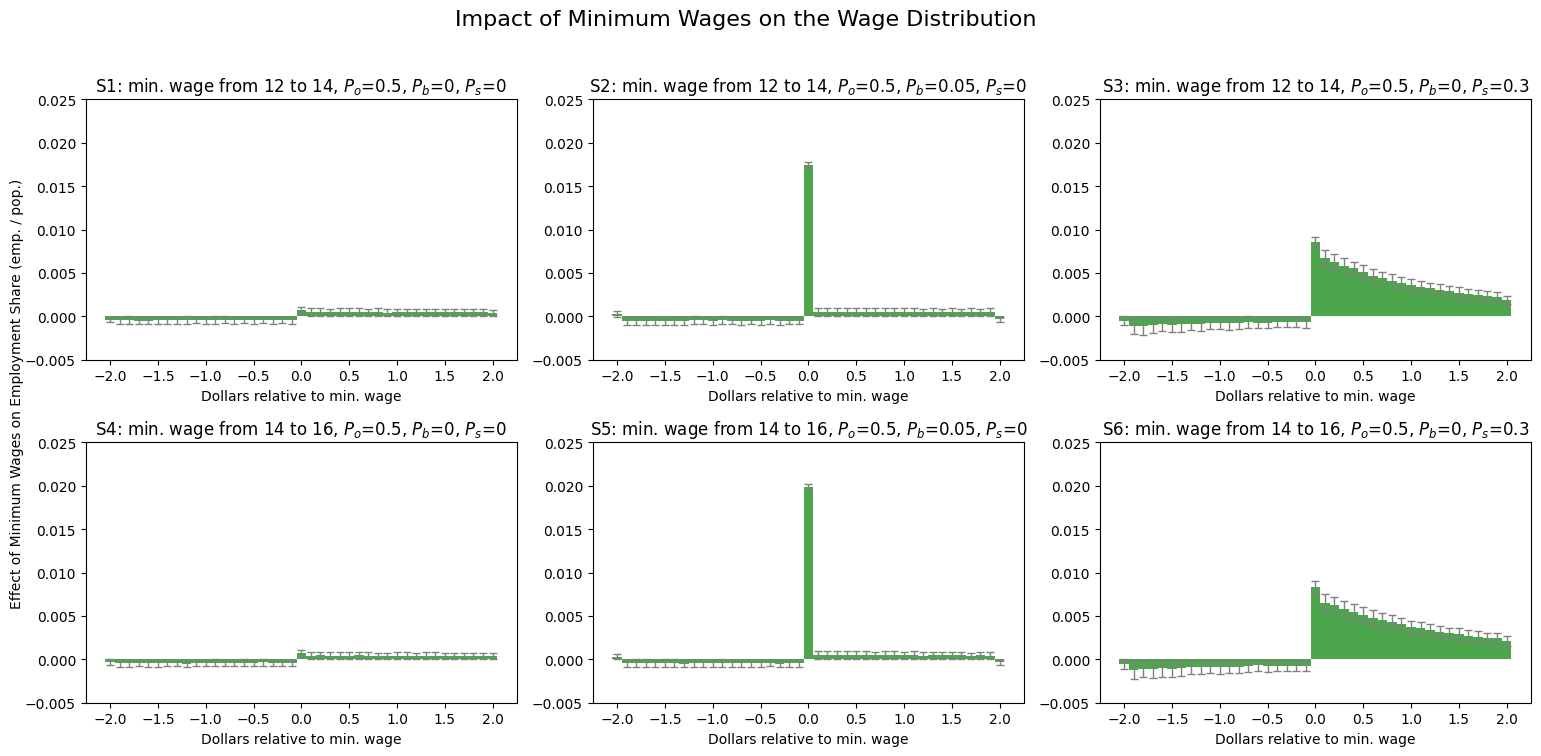

In [191]:
# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# Generate and plot results for each scenario
for ax, (scenario_name, scenario) in zip(axs.flatten(), scenarios.items()):
    plot_cengiz_fe(log_wages, scenario)
    
# Set common ylabel
fig.text(0.04, 0.5, 'Effect of Minimum Wages on Employment Share (emp. / pop.)', va='center', rotation='vertical')
plt.suptitle('Impact of Minimum Wages on the Wage Distribution', fontsize=16)
# only show legend for panel 3
# axs[0, 1].legend()

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()

Next I replicate the main result plot in Cengiz et al.(2019). The y-axis is the difference between the actual employment and counterfacutal employment in the absent of minimum wage, normalized by the total employment in the previous period.

In [194]:
def plot_cengiz_counterfactual(log_wages, scenario, tot_population=1_000_000):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenario
    data = prepare_cengiz_data(log_wages, scenario)
    data = data.set_index(['wagcat', 'time'])

    # Prepare the independent variables (min* and bin* dummies)
    X = data.filter(regex='^(min\\d{1,2}|time|wagcat)').copy()
    X = sm.add_constant(X)
    y = data['normalized_emp']

    # # Fit the OLS model
    model = PanelOLS(y, X, entity_effects=True, time_effects=False).fit(cov_type='clustered', cluster_entity=True)

    # Create a copy of the original data
    df_counterfactual = data.copy()
    # Identify columns starting with 'min'
    min_columns = [col for col in df_counterfactual.columns if col.startswith('min')]
    # Set these columns to 0
    df_counterfactual[min_columns] = 0 
    # predict counterfactual employment
    df_counterfactual['pred_emp'] = model.predict(df_counterfactual[X.columns])
    # calculate the difference between actual and predicted employment using post period data
    tot_emp_pre = df_counterfactual[df_counterfactual['period'] == 'pre']['fweight'].sum()
    df_counterfactual_post = df_counterfactual[df_counterfactual['period'] == "post"]
    df_counterfactual_post['emp_diff'] = (df_counterfactual_post['normalized_emp'] - df_counterfactual_post['pred_emp']) * tot_population / tot_emp_pre

    # sort from lowest bin
    df_counterfactual_post = df_counterfactual_post.sort_values('rel_pos')

    # running sum of emp change 
    df_counterfactual_post['emp_diff_sum'] = df_counterfactual_post['emp_diff'].cumsum()
    df_counterfactual_post['rel_dollar'] = df_counterfactual_post['rel_pos'] * 0.1

    ax.bar(df_counterfactual_post['rel_dollar'], df_counterfactual_post['emp_diff'], width=0.1, color='blue', alpha=0.7, label='Change in Employment')
    
    ax.set_xlabel('Bins relative to new MW')
    # ax.set_ylabel('% Change in Employment Relative to Pre-Total Employment')
    ax.set_title(f'{scenario_name}: min. wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    ax.set_xlabel('Dollars relative to min. wage')
    ax.set_xticks(np.arange(-2, 2.1, 0.5))
    ax.set_xlim(-2.0, 2.0)
    ax.set_ylim(-0.005, 0.08)
    plt.tight_layout()


/var/folders/38/gxfq51hs21135y6v6ch36cc40000gn/T/ipykernel_19781/3533455200.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_counterfactual_post['emp_diff'] = (df_counterfactual_post['normalized_emp'] - df_counterfactual_post['pred_emp']) * tot_population / tot_emp_pre
/var/folders/38/gxfq51hs21135y6v6ch36cc40000gn/T/ipykernel_19781/3533455200.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_counterfactual_post['emp_diff'] = (df_counterfactual_post['normalized_emp'] - df_counterfactual_post['p

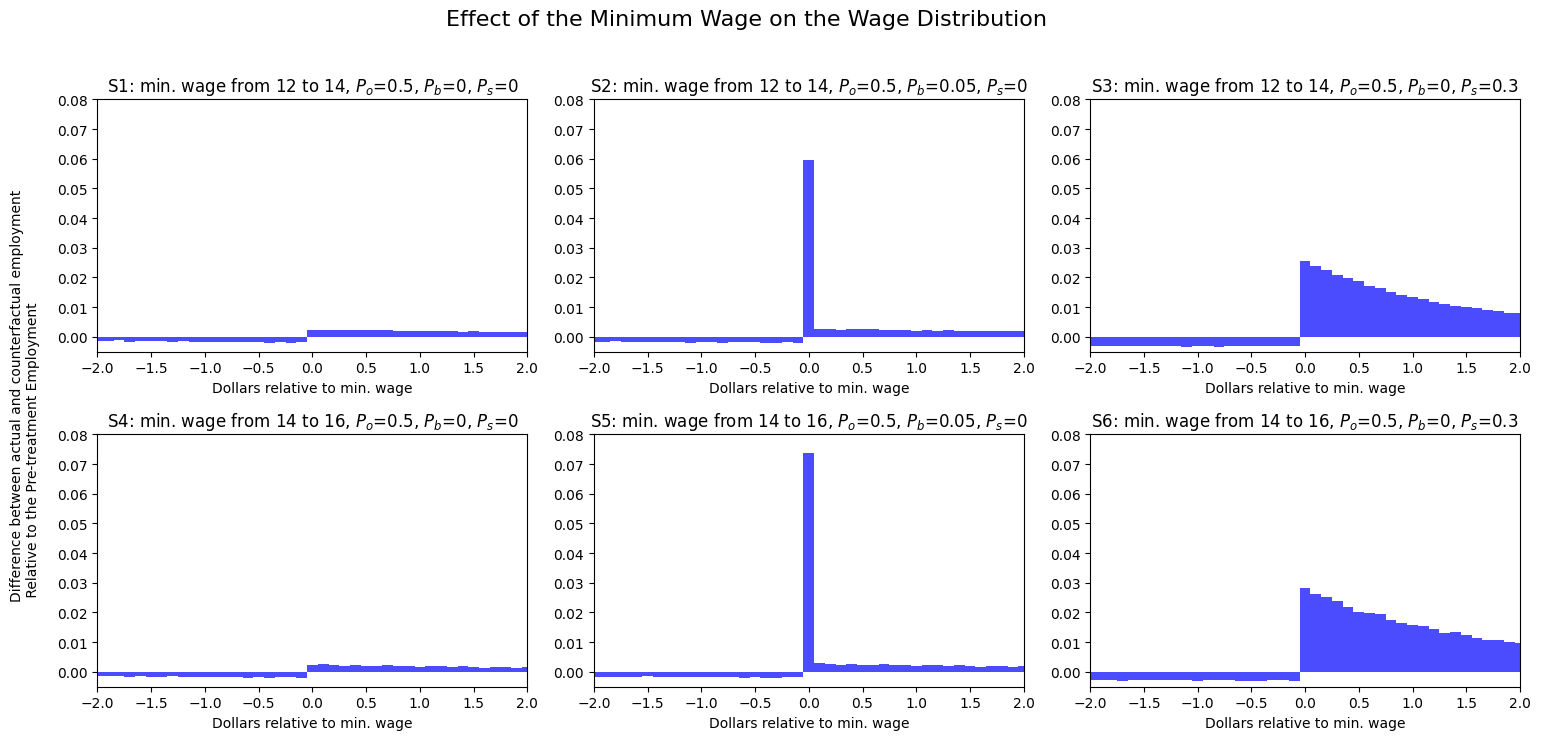

In [195]:
# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# Generate and plot results for each scenario
for ax, (scenario_name, scenario) in zip(axs.flatten(), scenarios.items()):
    tot_population = np.shape(log_wages)[0]
    plot_cengiz_counterfactual(log_wages, scenario, tot_population)

# Set common ylabel
fig.text(0.04, 0.5, 'Difference between actual and counterfactual employment \n Relative to the Pre-treatment Employment', va='center', rotation='vertical')
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.06, 0.06, 1, 0.96])
plt.show()

Takeaways:

- The two ways shows the same patterns of the Cengiz method.
- In S1 and S4, null effect in all cells above the minimum wage; small but significant effect in most cells below the minimum wage
- In S2 and S5, huge bunching effect even with small probability of bunching.
- In S3 and S6, obvious spillover effect reflecting the shape of the exponential distribution of the spillover. The size of the coefficient is unaffected by the pre-existing employment in those bins.
- The spillover and bunching effect are stronger in S4-S6 than S1-S3, as more people were affected. The difference is however not obvious.

## Hazard Estimator


I first prepare the data and variables following the definition that Thomas gave me.

In [196]:
def prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o=0.2, P_b=0, P_s=0.5, append_unaffected_wages = False):

    # Assuming impose_minimum_wage function is defined elsewhere
    df_pre = impose_minimum_wage(log_wages, real_m_pre, P_o, P_b, P_s)
    df_post = impose_minimum_wage(log_wages, real_m_post, P_o, P_b, P_s)
    
    df_pre['real_wages'] = np.exp(df_pre['adjusted_log_wages'])
    df_post['real_wages'] = np.exp(df_post['adjusted_log_wages'])

    # drop the unemployed
    df_pre = df_pre.dropna(subset=['real_wages'])
    df_post = df_post.dropna(subset=['real_wages'])

    # Simplify bins
    bins = [0] + list(np.arange(3, 4, 0.5)) + list(np.arange(4, 20, 0.1)) + [20, np.inf]
    min_vars = ['min', 'min21b', 'min1620b', 'min1115b','min610b', 'min35b', 'min12b', 'min12a', 'min35a', 'min610a', 'min1115a', 'min1620a']

    def create_min_dummies(df, real_m):
        # Create bins and labels
        df['wagcat'] = pd.cut(df['real_wages'], bins=bins, labels=False, duplicates='drop')
        # Change wagcat to be integer or NaN
        df['wagcat'] = df['wagcat'].astype('Int64')

        # Find the bin number containing the minimum wage
        m_bin = pd.cut([real_m], bins=bins, labels=False, duplicates='drop')[0]

        # Aggregate data by bin
        df_grouped = df.groupby('wagcat').size().reset_index(name='fweight')
        max_bin = df_grouped['wagcat'].max()
        all_bins = pd.DataFrame({'wagcat': range(max_bin + 1)})
        df_grouped = pd.merge(all_bins, df_grouped, on='wagcat', how='left').fillna(0)

        # Create min and min* variables
        df_grouped['min'] = np.where(df_grouped['wagcat'] == m_bin, 1, 0)
        df_grouped['min21b'] = np.where((df_grouped['wagcat'] <= m_bin - 21), 1, 0)
        df_grouped['min1620b'] = np.where((df_grouped['wagcat'] >= m_bin - 20) & (df_grouped['wagcat'] <= m_bin - 16), 1, 0)
        df_grouped['min1115b'] = np.where((df_grouped['wagcat'] >= m_bin - 15) & (df_grouped['wagcat'] <= m_bin - 11), 1, 0)
        df_grouped['min610b'] = np.where((df_grouped['wagcat'] >= m_bin - 10) & (df_grouped['wagcat'] <= m_bin - 6), 1, 0)
        df_grouped['min35b'] = np.where((df_grouped['wagcat'] >= m_bin - 5) & (df_grouped['wagcat'] <= m_bin - 3), 1, 0)
        df_grouped['min12b'] = np.where((df_grouped['wagcat'] >= m_bin - 2) & (df_grouped['wagcat'] <= m_bin - 1), 1, 0)
        df_grouped['min12a'] = np.where((df_grouped['wagcat'] >= m_bin + 1) & (df_grouped['wagcat'] <= m_bin + 2), 1, 0)
        df_grouped['min35a'] = np.where((df_grouped['wagcat'] >= m_bin + 3) & (df_grouped['wagcat'] <= m_bin + 5), 1, 0)
        df_grouped['min610a'] = np.where((df_grouped['wagcat'] >= m_bin + 6) & (df_grouped['wagcat'] <= m_bin + 10), 1, 0)
        df_grouped['min1115a'] = np.where((df_grouped['wagcat'] >= m_bin + 11) & (df_grouped['wagcat'] <= m_bin + 15), 1, 0)
        df_grouped['min1620a'] = np.where((df_grouped['wagcat'] >= m_bin + 16) & (df_grouped['wagcat'] <= m_bin + 20), 1, 0)
        df_grouped['min_bin'] = m_bin
        df_grouped['rel_min_bin'] = df_grouped['wagcat'] - m_bin

        # Create bin* dummies
        bin_dummies = pd.get_dummies(df_grouped['wagcat'], prefix='bin')
        df_grouped = pd.concat([df_grouped, bin_dummies], axis=1)
        
        return df_grouped

    # Create min dummies and group by bin-period for both pre and post data
    df_grouped_pre = create_min_dummies(df_pre, real_m_pre)
    df_grouped_pre['period'] = 'pre'

    df_grouped_post = create_min_dummies(df_post, real_m_post)
    df_grouped_post['period'] = 'post'

    # Combine pre and post data
    df_grouped = pd.concat([df_grouped_pre, df_grouped_post])

    if append_unaffected_wages:
        df_raw = pd.DataFrame()
        df_raw['real_wages'] = np.exp(log_wages)
        
        # Create bins and labels
        df_raw['wagcat'] = pd.cut(df_raw['real_wages'], bins=bins, labels=False, duplicates='drop')
        # Change wagcat to be integer or NaN
        df_raw['wagcat'] = df_raw['wagcat'].astype('Int64')
        
        # Aggregate data by bin
        df_grouped_raw = df_raw.groupby('wagcat').size().reset_index(name='fweight')
        # define all var in min_vars to be 0
        df_grouped_raw[min_vars] = 0
        # Create bin* dummies
        bin_dummies = pd.get_dummies(df_grouped_raw['wagcat'], prefix='bin')
        df_grouped_raw = pd.concat([df_grouped_raw, bin_dummies], axis=1)
        df_grouped_raw['period'] = 'counterfactual'
        df_grouped = pd.concat([df_grouped, df_grouped_raw])

    max_bin = df_grouped['wagcat'].max()


    # Calculate remain: cumulative sum of fweight in descending order of bins
    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'], ascending=[True, False])
    df_grouped['remain'] = df_grouped.groupby('period')['fweight'].cumsum()
    df_grouped['hazard'] = df_grouped['fweight'] / df_grouped['remain']

    # assert that by group, remain - remain.shift(1) == fweight
    df_grouped = df_grouped.sort_values(by=['period', 'wagcat'])

    # # group by period: df_grouped['remain_diff'] = df_grouped['remain'].diff()
    df_grouped['remain_diff'] = df_grouped.groupby('period')['remain'].diff()
    df_grouped['lag_fweight'] = df_grouped.groupby('period')['fweight'].shift(1)

    # check if df_grouped[(df_grouped['lag_fweight'] + df_grouped['remain_diff'] == 0) | df_grouped['remain_diff'].isna()].shape[0] == df_grouped.shape[0]
    assert (df_grouped[(df_grouped['lag_fweight'] + df_grouped['remain_diff'] == 0) | df_grouped['remain_diff'].isna()].shape[0] == df_grouped.shape[0]), "Sanity check failed: remain - remain.shift(1) != fweight for some rows"

    # check fweight > 0 for all rows
    assert (df_grouped['fweight'] > 0).all(), "Sanity check failed: fweight <= 0 for some rows"

    # generate ln(-ln(1 - h(y))) as cloglog_hazard
    df_grouped['cloglog_hazard'] = np.log(-np.log(1 - df_grouped['fweight'] / df_grouped['remain']))

    # check cloglog_hazard is not NaN if wagcat is not 161
    assert df_grouped[df_grouped['wagcat'] != max_bin]['cloglog_hazard'].notna().all(), "Sanity check failed: cloglog_hazard is NaN for some rows where wagcat != 161"
    #drop wagcat == 161
    df_grouped = df_grouped[df_grouped['wagcat'] != max_bin]

    # Sanity check 1: sum of min* variables must be 0 or 1
    df_grouped['min_sum'] = df_grouped[min_vars].sum(axis=1)
    assert df_grouped['min_sum'].isin([0, 1]).all(), "Sanity check failed: sum of min* variables is not 0 or 1 for some rows."

    # Sanity check 2: sum of bin* variables must be 1
    bin_vars = [col for col in df_grouped.columns if col.startswith('bin')]
    df_grouped['bin_sum'] = df_grouped[bin_vars].sum(axis=1)
    assert (df_grouped['bin_sum'] == 1).all(), "Sanity check failed: sum of bin* variables is not 1 for some rows."

    # drop bin_sum and min_sum columns
    df_grouped = df_grouped.drop(columns=['bin_sum', 'lag_fweight', 'remain_diff'])
    
    return df_grouped

Create data for four scenarios.

In [197]:
# df_appended = pd.DataFrame()

# loop through the scenarios
for scenario, params in scenarios.items():
    real_m_pre, real_m_post, P_o, P_b, P_s = params
    df_grouped = prepare_hazard_var(log_wages, real_m_pre, real_m_post, P_o, P_b, P_s)
    df_grouped['Scenario'] = scenario
    # df_appended = pd.concat([df_appended, df_grouped])
    print(f"Scenario: {scenario}")
    # print #rows fweight ==0
    # print(df_grouped[df_grouped['fweight']==0].shape[0])
    df_grouped.to_stata(f'data/df_grouped_{scenario}.dta')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Scenario: S5
Scenario: S6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
# %pip install stata_setup
import stata_setup
stata_setup.config("/Applications/Stata/", "se")

In [51]:
%%stata
# execute the following do.file
do "codes/hazard simulation.do"


. # execute the following do.file
Unknown #command
. do "codes/hazard simulation.do"

. cd "/Users/boyuchen/Documents/UBC/RA/minimum_wage"
/Users/boyuchen/Documents/UBC/RA/minimum_wage

. 
. * Clear the existing Excel file or create a new one
. putexcel set tables/glm_coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. putexcel set tables/ols_coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. putexcel set tables/lpm_coefficients.xlsx, replace
note: file will be replaced when the first putexcel command is issued.

. 
. foreach s in S1 S2 S3 S4 S5 S6{
  2. quietly{
  3.     
.         di "Run GLM for scenario `s'"
  4.         use data/df_grouped_`s'.dta, clear
  5.         drop min_bin rel_min_bin min_sum
  6.         
.         glm fweight min* bin* if remain>0 & wagcat ~= 0, link(cloglog) family
> (binomial remain) 
  7.         
.     * Extract the coefficients
.     matrix b = e(b)
  

### Notes

- As shown in both the regression results above and figures below, we observed significant positive coefficient in the bins above the minimum wage, which is confusing since there shouldn't be any spillover effect in S1 to S3. 

- I'm thinking if it has anything to do with the "binomial" assumption. Does the distribution assumption impose `fweight` or `fweight`/`remain` to follow a bell shape, or it means something else? If my guess is correct, since the distribution of S1 and S2 are truncated bell shape, to match the bell shape of binomial we got negative coefficients in bins below minimum wage and positive coefficients for bins above, even for `min1620a`. 

- Does the issue only happen in my simulation context? How does the full model avoid this issue with real world data (many period and states.)


In [199]:
# Define the x-axis ranges for the variables
# x_ranges = {
#     'min': (0, .1),
#     'min6b': (-2.0, -.5),
#     'min35b': (-.5, -.2),
#     'min12b': (-.2, .0),
#     'min12a': (.1, .3),
#     'min35a': (.3, .6),
#     'min610a': (.6, 1.1),
#     'min1115a': (1.1, 1.6),
#     'min1620a': (1.6, 2.0)
# }

x_ranges = {
    'min': (0, .1),
    'min610b': (-1.0, -.5),
    'min1115b': (-1.5, -1.0),
    'min1620b': (-2.0, -1.5),
    'min21b': (-2.5, -2.0),
    'min35b': (-.5, -.2),
    'min12b': (-.2, .0),
    'min12a': (.1, .3),
    'min35a': (.3, .6),
    'min610a': (.6, 1.1),
    'min1115a': (1.1, 1.6),
    'min1620a': (1.6, 2.0)
}

In [200]:
# Load the Excel file
file_path = 'tables/glm_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

glm_result = pd.concat([format_data(file_path, scenario) for scenario in scenarios.keys() ])

# Filter the data for the variables of interest
glm_result = glm_result[glm_result['Variable'].isin(x_ranges.keys())]


In [201]:
# prepare df to overlay the glm coefficients
def prepare_fweight_df(df_appended, scenario):
    df_appended['rel_bin'] = df_appended['wagcat'] - df_appended['min_bin']
    df = df_appended[(df_appended['rel_bin'] >= -10) & (df_appended['rel_bin'] <= 20)]
    # rel_dollar is the relative bin * 10
    df['rel_dollar'] = df['rel_bin'] * 0.1
    df_pre = df[(df['period']=='pre') & (df['Scenario']==scenario)]
    df_post = df[(df['period']=='post') & (df['Scenario']==scenario)]
    df_pre = df_pre[['rel_dollar', 'fweight']]
    df_post = df_post[['rel_dollar', 'fweight']]
    df_pre.columns = ['rel_dollar', 'fweight_pre']
    df_post.columns = ['rel_dollar', 'fweight_post']
    df_fweight = pd.merge(df_pre, df_post, on='rel_dollar', how='outer')

    return df_fweight

# prepare_fweight_df(df_appended, 'S1')

In [202]:
# Load the Excel file
file_path = 'tables/ols_coefficients.xlsx'

# Function to format the data
def format_data(file_path, scenario):
    df = pd.read_excel(file_path, sheet_name=scenario, header=None)
    variables = df.iloc[1, 1:].values
    coefficients = df.iloc[2, 1:].values
    se = df.iloc[3, 1:].values
    data = pd.DataFrame({
        'Variable': variables,
        'Coefficient': coefficients,
        'SE': se,
        'Scenario': scenario
    })

    # only keep columns where variable start with "min"
    data = data[data['Variable'].str.startswith('min')==True]

    return data

ols_result = pd.concat([format_data(file_path, scenario) for scenario in scenarios.keys() ])

# Filter the data for the variables of interest
ols_result = ols_result[ols_result['Variable'].isin(x_ranges.keys())]


Tried OLS and got the same coefficients. The SE from OLS are unadjusted.

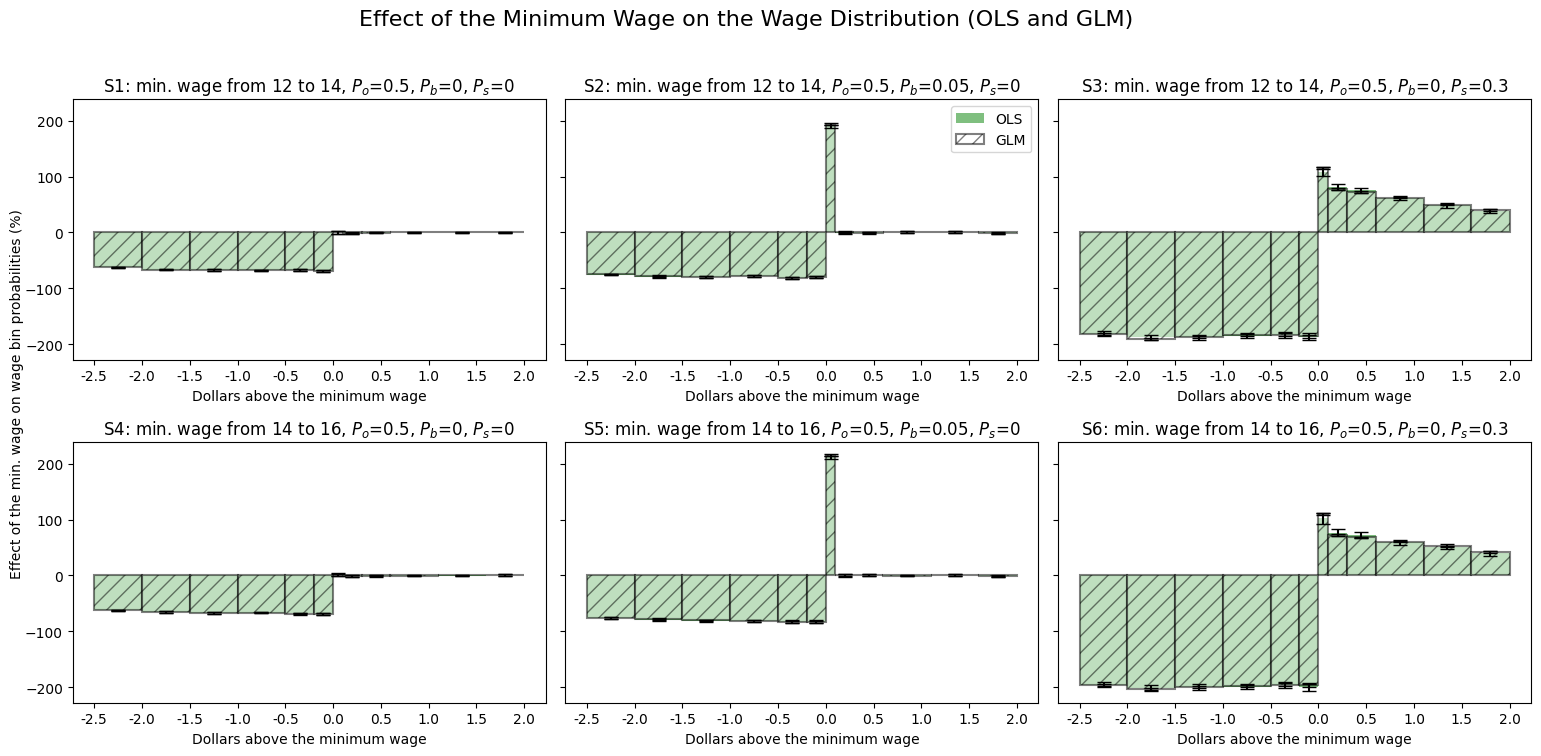

In [203]:
glm_result['Model'] = 'glm'
ols_result['Model'] = 'ols'
result_appended = pd.concat([glm_result, ols_result])

# Define the figure and axes for subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each scenario in a separate subplot
for i, scenario in enumerate(scenarios):
    real_m_pre, real_m_post, P_o, P_b, P_s = scenarios[scenario]
    scenario_data_ols = result_appended[(result_appended['Scenario'] == scenario) & (result_appended['Model'] == 'ols')]
    scenario_data_glm = result_appended[(result_appended['Scenario'] == scenario) & (result_appended['Model'] == 'glm')]
    
    x_scenario_values_ols = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data_ols['Variable']]  # Convert to percentage
    y_values_ols = scenario_data_ols['Coefficient'] * 100  # Convert to percentage
    y_err_ols = scenario_data_ols['SE'] * 100  # Convert to percentage
    scenario_widths_ols = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data_ols['Variable']]  # Convert to percentage

    x_scenario_values_glm = [np.mean([x_ranges[var][0], x_ranges[var][1]]) for var in scenario_data_glm['Variable']]  # Convert to percentage
    y_values_glm = scenario_data_glm['Coefficient'] * 100  # Convert to percentage
    y_err_glm = scenario_data_glm['SE'] * 100  # Convert to percentage
    scenario_widths_glm = [(x_ranges[var][1] - x_ranges[var][0]) for var in scenario_data_glm['Variable']]  # Convert to percentage
    
    # Plot the OLS data
    axes[i].bar(x_scenario_values_ols, y_values_ols, width=scenario_widths_ols, yerr=y_err_ols, capsize=5, label='OLS', color='green', alpha=0.5)
    
    # Plot the GLM data with hollow bars 
    axes[i].bar(x_scenario_values_glm, y_values_glm, width=scenario_widths_glm, yerr=y_err_glm, capsize=5, label='GLM', color='white', alpha=0.5, edgecolor='black', linewidth=1.5, hatch='//')
    
    # add old and new minimum wage lines with legend
    # axes[i].axvline(x=real_m_pre - real_m_post, color='blue', linestyle='--', linewidth=2, label='Original minimum wage')
    # axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, label='New minimum wage')
         
    axes[i].set_xlabel('Dollars above the minimum wage')
    axes[i].set_title(f'{scenario}: min. wage from {real_m_pre} to {real_m_post}, $P_o$={P_o}, $P_b$={P_b}, $P_s$={P_s}')
    
    # Set x-ticks with a break of 5 bins (0.5 dollars)
    axes[i].set_xticks(np.arange(-2.5, 2.1, .5))
    axes[i].set_xticklabels(np.arange(-2.5, 2.1, 0.5))

# Set common ylabel
fig.text(0.04, 0.5, 'Effect of the min. wage on wage bin probabilities (%)', va='center', rotation='vertical')

# Set the main title
plt.suptitle('Effect of the Minimum Wage on the Wage Distribution (OLS and GLM)', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])

# Add a legend
# handles, labels = axes[0].get_legend_handles_labels()
axes[1].legend()

# fig.legend(handles, labels, loc='upper right')

plt.show()

# Takeaways

- The hazard estimation and Cengiz et al.(2019) both shows the negative employment effect below the minimum wage, and null effect when the model has no bunching or spillover. However, the Cengiz et al.(2019) method largely depends on the numbers of employments in a given bin prior to the minimum wage change. In bins with more counts we will observe a larger negative impact (such as the original minimum wage bin). Such an effect was not observed in the hazard estimation.
- In the hazard estimation, using the GLM and OLS gives the exactly same coefficients. The hazard estimation captures the "drop" for all cells below new minimum wage.
- The naive approach that compares the wage percentile of employed workers captures fallacious spillover effects when there are not (See S1, S2, and S3)

## Interpretation

- Other than the naive approach, the three figures have slightly different interpretations. The first (Cengiz et al. coefficient) shows the effect in employment relative to the total population, so it is unaffected by the employment effect such that many people got unemployeed; the second (Cengiz et al. difference in actual and counterfactual) shows a very similar trend, but it is normalized with the total employment in the previous period, which is also unaffected by the employment effect of the current period. The hazard estimator rules out the employment effect of minimum wage by only consider the relative changes in bins and above (hazard), so any affects on bins below won't create spurious spillover.